<div>
<img align="left" src="data_sig_logo.jpg" width="450"/>
</div>

### https://datasig.ac.uk/examples

# Path Signatures for Drone Identification using $\texttt{esig}$

### Jessica Toudic, Peter Foster, and Terry Lyons

This notebook demonstrates the use of **path signatures** for identifying drones similar to this one:

![title](img/256px-Quadcopter_camera_drone_in_flight.jpg)

More specifically, we will use the Python package [esig](https://esig.readthedocs.io/) to compute the path signatures of simulated radio waves reflected off the surface of drone and non-drone objects. Our mathematical model of a drone consists of a slowly moving body and a single, rapidly moving propeller. Relative to an observer who emits radio pulses and receives their reflections, owing to propagation time delay and Doppler shift we expect that the signal characteristics of radio pulses reflected off the drone's propeller differ from the signal characteristics of radio pulses reflected off the drone's body.

We will attempt to distinguish between drone and non-drone objects, where we assume that when we reflect a radio pulse off drones, the reflected signal received back by the observer is the combination of the reflection caused by the drone's body and the reflection caused by the drone's propeller. Our non-drone model consists of a slowly moving body (identical to the one used in the drone), omitting the propeller present in the drone model.

The core mathematical object that we will use to construct our features is a sequence of iterated integrals, known as the path signature. We compute path signatures up to a specified truncation level, which yields a low-dimensional representation of the $N$-dimensional path $X:[a, b]\to \mathbb{R}^N$. We will construct piecewise linear paths from  pairs of successively observed reflected radio pulses by stacking their time series.

Subsequently, we will estimate **expected path signatures** by averaging path signatures obtained for several thousand simulated radio pulses reflected off drone objects with varying propeller locations. The approach of using expected path signatures aims at characterising random behaviour in reflected signals. Taking estimates of expected path signatures as our feature vectors, we will consider the task of distinguishing between drone and non-drone objects, in addition to predicting the number of rotations per minute (RPM) of the drone's propeller.

Note that the principal aim of this notebook is to demonstrate the use of path signatures qualitatively and from a practical perspective, using $\texttt{esig}$. A more detailed analysis might involve quantifying predictive accuracy using a broader range of parameters and evaluating the effect of adding noise to the signals, in addition multi-path propagation.

# Method

## Drone Model
We consider a low speed body roughly $30$cm in diameter. A rotating device placed on top of the drone represents a propeller with two blades. In this way, we model a drone as a two-component system, consisting of a body and a propeller.

Our incident signal is an electromagnetic sine wave comprising $1000$ wavelengths. The sine wave has frequency $\mathcal{f}=1$GHz, thus its wavelength is approximately $30$cm. When the incident signal hits either of the two moving objects, it reflects off them. The reflected signal is a linear combination of the reflections produced by the drone's body and the drone's propeller. For the purpose of this notebook we will consider a pulse rate of $3$kHz. An observer positioned at a fixed location emits the incident signals and observes the reflected signals.

We model the drone's body as a perfect mirror, located on a plane perpendicular to the observer and moving at constant speed relative to the observer. We assume a propeller with diameter $d$, and further assume that each individual point on the propeller is a tiny perfect mirror perpendicular to the observer and moving at constant velocity relative to the observer. The speed of the propeller acting as a mirror varies according to the distance along the propeller blade and further depends on the number of rotations per minute (RPM), as well as the propeller's angle when the reflection occurs. We also assume that the entire signal hits the same 'tiny mirror'. That is, the mirror's speed and position remain constant for the duration of the reflection; the mirror does not change direction and thus does not accelerate. We assume that the observer generates $3000$ incident signals which consequently undergo reflection by the drone's body and propeller. These reflected signals are subsequently received back by the observer for analysis.

We model the incident signal $\mathcal{E}_{\text{inc}}(x,t)$ observable at location $x$ and time $t$ as a monochromatic plane wave moving in the positive x-direction away from the observer located at position $x_0=0$. The incident signal has angular frequency $\omega_{\text{inc}} = 2\pi\mathcal{f}_{\text{inc}}$, wavenumber $k = \frac{\omega_{\text{inc}}}{c}$ and amplitude $A_{\text{inc}}$,

$$\mathcal{E}_{\text{inc}}(x,t) = A_{\text{inc}} \hspace{0.05cm} sin(\omega_{\text{inc}} t - kx)$$

where we use the subscript $\text{inc}$ to denote that we are dealing with the incident signal.

We compute the mirror speed $v$ and mirror position $r_0$ as follows: we assume that the centre of the two blades is the same distance $z$ from the observer as the drone's body. We denote with $\theta$ the anticlockwise angle between the the plane of the drone's body and propeller blade. We denote with $d$ the diameter of the propeller, and denote with $p$ the position along the blade where the incident signal is reflected. Furthermore, we denote with $R$ the propeller's speed in RPM. For the cases where $\theta=\frac{\pi}{2}$ or $\theta=\frac{3\pi}{2}$, we assume that then the signal has hit the end of the propeller blade, which has velocity zero with respect to the moving body. Denoting with $v_b$ the velocity of the moving body, we define

$$r_0 =
    \begin{cases}
        z-\frac{d}{2} &\quad\text{if}~\theta=\frac{\pi}{2}~\text{or}~\theta=\frac{3\pi}{4}\\
        p\,sin(\theta) + z &\quad\text{otherwise}\\
    \end{cases}
$$

and 

$$v = 
    \begin{cases}
        v_b &\quad\text{if} \theta=\frac{\pi}{2}~\text{or}~\theta=\frac{3\pi}{4}\\
        v_b + 2 \pi p\left(\frac{R}{60}\right) &\quad\text{otherwise.}\\
    \end{cases}
$$
    
When the incident signal hits and reflects off an object moving at constant velocity, we observe a change in the the signal's frequency, which depends on the object's velocity and the signal's direction of propagation. This change in frequency is known as the [Doppler effect](https://en.wikipedia.org/wiki/Doppler_effect). According to [1], for the propeller reflection $\mathcal{E}_{\text{prop}}(x,t)$ we have

$$\mathcal{E}_{\text{prop}}(x,t) = -\left( \frac{1-\frac{v}{c}}{1+\frac{v}{c}}\right) A_{\text{inc}} sin \left[ \left( \frac{1-\frac{v}{c}}{1+\frac{v}{c}}\right) \left(\omega_{\text{inc}} t + kx\right) - 2k\left(\frac{r_0 - v t_0}{1+\frac{v}{c}}\right) \right].$$

We denote with $s = \left( \frac{1-\frac{v}{c}}{1+\frac{v}{c}} \right)$ the factor by which the frequency changes. If $v>0$ (the object is moving away from the observer), we have $s<1$, and thus the frequency decreases. If $v<0$ (the object is moving towards the observer), we have $s>1$, and thus the frequency increases. Using $\omega_{\text{prop}}$, $A_{\text{prop}}$, $T_{\text{prop}}$ and $T_{\text{inc}}$ to denote respectively the propeller-reflected signal's angular frequency, the propeller-reflected signal's amplitude, the propeller-reflected signal's wave period and the incident signal's wave period, we have:

$$ 
\omega_{\text{prop}} = s \omega_{\text{inc}}, \hspace{1cm} A_{\text{prop}} = s A_{\text{inc}}, \hspace{1cm} T_{\text{prop}} =s^{-1} T_{\text{inc}}.\\
$$

We emit our 3000 incident signals towards our drone model one at a time as separate, evenly-spaced pulses; to avoid interference a pulse is only emitted after the previously reflected one has returned to the observer. As received by the observer, we assume that the reflected signal $\mathcal{E}_{\text{ref}}(x,t)$ is the arithmetic mean of the reflection $\mathcal{E}_{\text{prop}}(x,t)$ that we obtain for the drone's propeller and the reflection $\mathcal{E}_{\text{body}}(x,t)$ that we obtain for drone's body,
$$ \mathcal{E}_{\text{ref}}(x,t) = \frac{1}{2} \left(\mathcal{E}_{\text{prop}}(x,t) + \mathcal{E}_{\text{body}}(x,t) \right).$$
We define the body-reflected signal $\mathcal{E}_{\text{body}}(x,t)$ in the following sub-section (Non-Drone Model).

We model the propeller angle $\theta$ deterministically as a function of time $t$,
$$ \theta(t) = 2\pi t \frac{R}{60} + \theta_0$$
where $\theta_0$ is the initial angle and where $R$ is the propeller's speed in RPM. By contrast, we model event of a signal hitting the propeller at location $p$ as random, by sampling uniformly from the interval $[0, d/2)$. Analogously, we set the initial propeller angle $\theta_0$ by sampling randomly from the interval $[0, 2\pi)$.

## Non-Drone Model
Our non-drone model simply consists of a slowly moving body (identical to the one used in the drone), omitting the propeller present in the drone model. That is, in the non-drone model, the reflected signal $\mathcal{E}_{\text{body}}(x, t)$ is given by
$$\mathcal{E}_{\text{body}}(x,t) = -\left( \frac{1-\frac{v_b}{c}}{1+\frac{v_b}{c}}\right) A_{\text{inc}} sin \left[ \left( \frac{1-\frac{v_b}{c}}{1+\frac{v_b}{c}}\right) \left(\omega_{\text{inc}} t + kx\right) - 2k\left(\frac{z - v_b t_0}{1+\frac{v_b}{c}}\right) \right].$$
If we define $s' = \left( \frac{1-\frac{v_b}{c}}{1+\frac{v_b}{c}} \right)$ and use $\omega_{\text{body}}$, $A_{\text{body}}$, $T_{\text{body}}$ to denote respectively the body-reflected signal's angular frequency, the body-reflected signal's amplitude, the body-reflected signal's wave period, we have:

$$ 
\omega_{\text{body}} = s' \omega_{\text{inc}}, \hspace{1cm} A_{\text{body}} = s' A_{\text{inc}}, \hspace{1cm} T_{\text{body}} =s'^{-1} T_{\text{inc}}.\\
$$

## Pulse Durations
For each incident signal (comprising 1000 wavelengths), we generate $10^5$ samples, corresponding to a rate of 100 samples per wavelength. We assume that a given incident signal that we emit has respective start and end times $t_1$ and $t_2=t_1 + 1000 T_{\text{inc}}$, so that outside the interval $[t_1, t_2]$ the signal is zero. For a drone object, the respective start and end times $t_3$ and $t_4$ of the corresponding propeller-reflected signal $\mathcal{E}_{\text{prop}}(x, t)$ then satisfy
$$s \left(\omega_{\text{inc}} t_3 + kx\right) - 2k\left(\frac{r_0 - vt_0}{1+\frac{v}{c}}\right) = 0;\hspace{1cm} t_4 = t_3 + 1000T_{\text{prop}}.$$
Analogously, the start and end times $t'_3$ and $t'_4$ of the corresponding body-reflected signal $\mathcal{E}_{\text{body}}(x, t)$ satisfy
$$s' \left(\omega_{\text{inc}} t'_3 + kx\right) - 2k\left(\frac{z - v_b t_0}{1+\frac{v_b}{c}}\right) = 0;\hspace{1cm} t'_4 = t'_3 + 1000T_{\text{body}}.$$
It follows that as received by the observer, the reflected signal $\mathcal{E}_{\text{ref}}(x,t)$ has the respective start and end times $\min\{ t_3, {t'}_3\}$ and $\max\{ t_4, {t'}_4\}$.

## N-Dimensional Paths
An $N$-dimensional path is a mapping $X:[a, b]\rightarrow \mathbb{R}^N$ defined by $N$ piecewise smooth functions on the interval $[a, b]$. Equivalently, we may represent $X$ in terms of its real-valued coordinates $X(t)=(X_t^1, \ldots, X_t^N)$ parametrised by $t \in [a, b]$. In our case, we will construct a 3-dimensional path for the pair of successively reflected signals that the observer receives for each pair of successively emitted pulses. By considering successively reflected signals, we aim to normalise away the effect of the drone's body movement, as opposed to the effect of any propeller, the latter which we deem relevant for distinguishing drones from non-drones.

Let us first consider the 2-dimensional path $Y: [a,b] \rightarrow \mathbb{R}^2$. We obtain $Y$ by stacking the corresponding times series representing the reflected signal $\mathcal{E}_{\text{ref}}(x,t)$. (As a preceding step, we ensure that time series have equal length by applying zero padding to the end of the shorter of the two time series. Note that because our signals are sampled at finitely many times, to obtain $Y$ we implicitly interpolate between the *stream coordinates* $\hat{Y}(u_i)$ which we observe at discrete times $u_1, \ldots, u_M$.

### The Lead-Lag Transformation
Instead of operating on the described 2-dimensional path $Y$ directly, we construct a path $X$ of dimensionality $N=3$ as follows: First, we define the lead-transformed stream $\hat{Y}(j)^{\text{lead}}$ observed at times $1, \ldots, 2M$ as
$$
\hat{Y}(j)^{\text{lead}} =
    \begin{cases}
        \hat{Y}(u_i) \quad \text{if $j$ = 2i}\\
        \hat{Y}(u_i) \quad \text{if $j$ = 2i - 1}.
    \end{cases}
$$
Analogously, we define the lag-transformed stream $\hat{Y}(j)^{\text{lag}}$ observed at times $1, \ldots, 2M$ as
$$
\hat{Y}(j)^{\text{lag}} =
    \begin{cases}
        \hat{Y}(u_i) \quad \text{if $j$ = 2i}\\
        \hat{Y}(u_i) \quad \text{if $j$ = 2i + 1}.
    \end{cases}
$$
The lead-lag transformation $\hat{Y}^{\text{lead-lag}}$ of $\hat{Y}$ is the 4-dimensional stream that we obtain by stacking streams $\hat{Y}^{\text{lead}}$ and $\hat{Y}^{\text{lag}}$,
$$
\hat{Y}(j)^{\text{lead-lag}} = (\hat{Y}(j)^{\text{lead}}, \hat{Y}(j)^{\text{lag}}).
$$
Our motivation for using the lead-lag transformation is that it may facilitate representing the cross-variation between the original path and its delayed version [7]. In particular, we consider the 3-dimensional *partial lead-lag transformation* $\hat{X}$, which we obtain by stacking onto $\hat{Y}^{\text{lead}}$ only those vectors in $\hat{Y}^{\text{lag}}$ whose cross-variation we seek to represent. In our case, we specify
$$
\hat{X}(j) = (\hat{Y}(j)^{\text{lead}}, \hat{Y}(j)_{\text{ref}}^{\text{lag}})
$$
where subscript $\text{ref}$ denotes that we only consider the vector of interest, corresponding to the second of two lag-transformed reflected signals.

It is important to emphasise that in terms of our implementation, the core object that we operate on is the 3-dimensional stream $\hat{X}$ that we obtain for each pair of reflected signals. The path $X$ is the result of interpolating between stream coordinates in $\hat{X}$.

## Path Signatures

We wish to characterise our drone model using the **signature** of the path $X:[a,b]\rightarrow \mathbb{R}^N$, where we obtain a path $X$ for each of our 3000-1 pairs of reflected signals. For an introduction to path signatures, we refer the reader to [5].

From an informal perspective, the signature $S(X)$ is the infinite ordered set of real-valued terms
\begin{align}
S(X) &= (1, S^1, S^2, \ldots,  S^N,\\
     &\quad \quad S^{1, 1}, S^{1, 2}, \ldots, S^{N, N},\\
     &\quad \quad S^{1, 1, 1}, S^{1, 1, 2}, \ldots, S^{N, N, N},\\
     &\quad \quad \ldots)
\end{align}
with term $S^{(i_1,...,i_k)}$ at index $(i_1,...,i_k)$ defined as the $k$-fold iterated path integral
$$
S^{(i_1,...,i_k)} = \int\limits_{a < r_k < b} \ldots \int\limits_{a < r_1 < r_2} \,dX^{i_1}_{r_1} \ldots \,dX^{i_k}_{r_k}.
$$

The signature $S(X)$ is known to determine $X$ uniquely up to tree-like equivalence $[3]$.

Due to computational constraints, we cannot compute the entire path signature. Therefore, in practice we truncate the signature to order $K \geq k$, thus obtaining $\sum_{k=0}^{k=K} N^{k}$ terms. For example, if we truncate to order $K=2$, the signature of a 2-dimensional path consists of the terms

$$ S(X) =\big( 1 ,  S^{(1)}(X) , S^{(2)}(X) , S^{(1,1)}(X), S^{(1,2)}(X), S^{(2,1)}(X), S^{(2,2)}(X) \big).$$

From now on, when we refer to path signatures we will mean the truncated path signatures.

Note that if we set $K$ too small, we may discard important information characterising our drone model. Conversely, if we set $K$ too large, we may end up including information which is redundant for our task.

## Expected Path Signatures

A stochastic process is uniquely characterised by its expected signature $[4]$. We will think of the reflections of signals off our drone model as samples from stochastic process. We seek to uniquely characterise our drone model by estimating its expected signature as the empirical mean of the 3000-1 individual signatures that we obtain from our reflected signal pairs. We consider the expected signature $E(S)$ truncated to order $K=2$.

# Computing Path Signatures Using $\texttt{esig}$

We use [esig](https://esig.readthedocs.io/en/latest/) to compute path signatures of our reflected signals.

For the aims of this notebook, we use $\texttt{esig}$'s function *esig.tosig.stream2sig(stream, truncation_level)*. This function computes the path signature up to a specified truncation level for a given N-dimensional coordinate stream. To obtain the indices of terms in the path signature, we use $\texttt{esig}$'s function *esig.tosig.sigkeys(n_dims, truncation_level)*.

We need to install required package dependencies, including $\texttt{esig}$:

Next, we import required packages:

In [101]:
import itertools

from expected_path_signatures import ExpectedSignatureCalculator

import esig
import joblib
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import scipy
import sklearn
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection
import sklearn.pipeline
import sklearn.preprocessing
import tqdm.notebook

import warnings

warnings.filterwarnings("ignore")

# Visualising Reflected Signals
Before attempting to distinguish between drone and non-drone objects using path signatures, let us visualise some examples of reflected signals as received by the observer. To this end, we use the methods *compute_reflected_signals_for_drone()* and *compute_reflected_signals_for_nondrone()*, both which are part of a class which implements the described models of drone and non-drone objects. We base our exploration on 20 simulated pulses reflected off objects moving at a speed of 40 metres per second and located 1000 metres from the observer. For the drone, we use a propeller diameter of 0.12 metres and consider RPM values in {7000, 14000, 21000}.

In the plots, the first first row displays reflections for the non-drone object; subsequent rows display results for the drone object with increasing RPM values between rows. The leftmost three columns display plots of the current reflection against the preceding reflection, for different portions of the reflection (initial 100 samples; final 100 samples; the entire signal excluding 100 samples at each end). Since we emit 20 pulses, there are 19 curves in each of these subplots, each corresponding to a pair of successively observed reflections.

The following two columns display plots of the reflections themselves, for different portions of the reflection (initial 100 samples; final 100 samples).

The final column summarises the shape of the plots in the third column: As our summary statistic, we use the mean squared error between the current reflection and the preceding reflection. In this way, we quantify how how strongly each of the curves in the third column departs from the diagonal shape that we observe for the non-drone object:

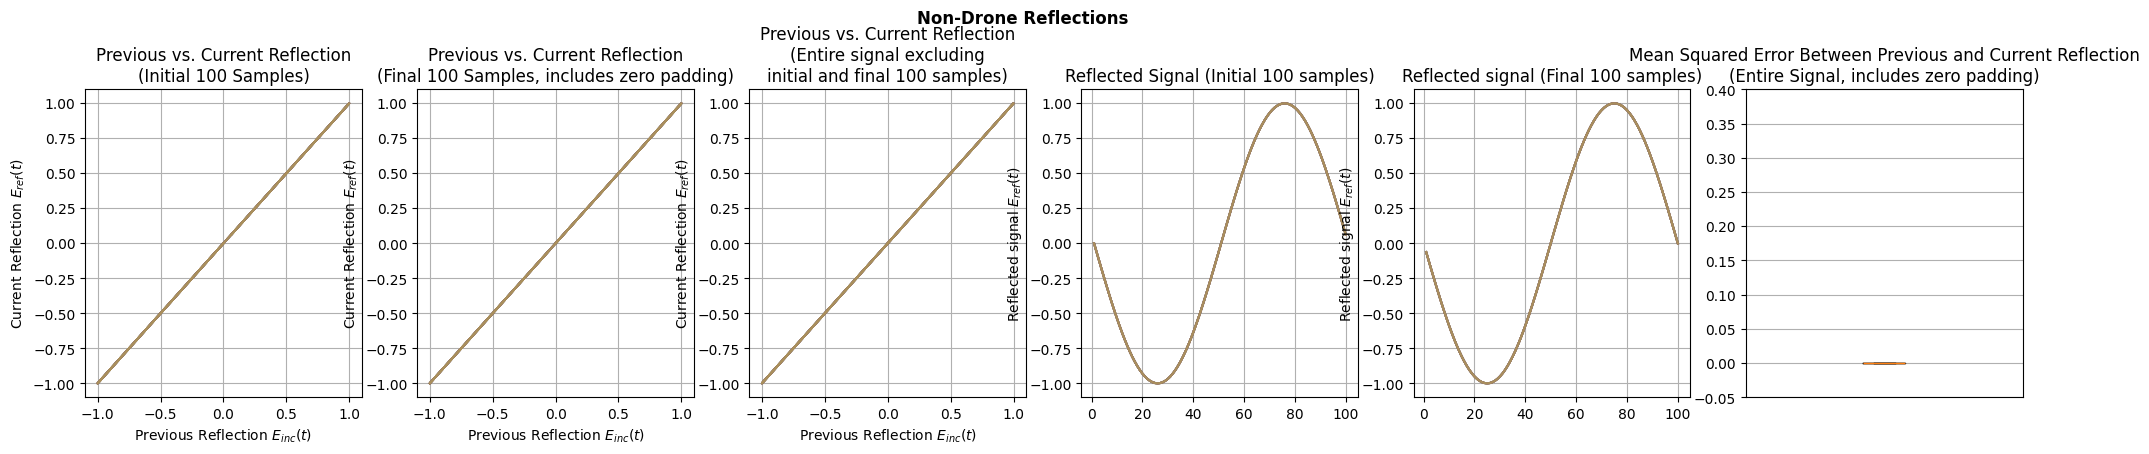

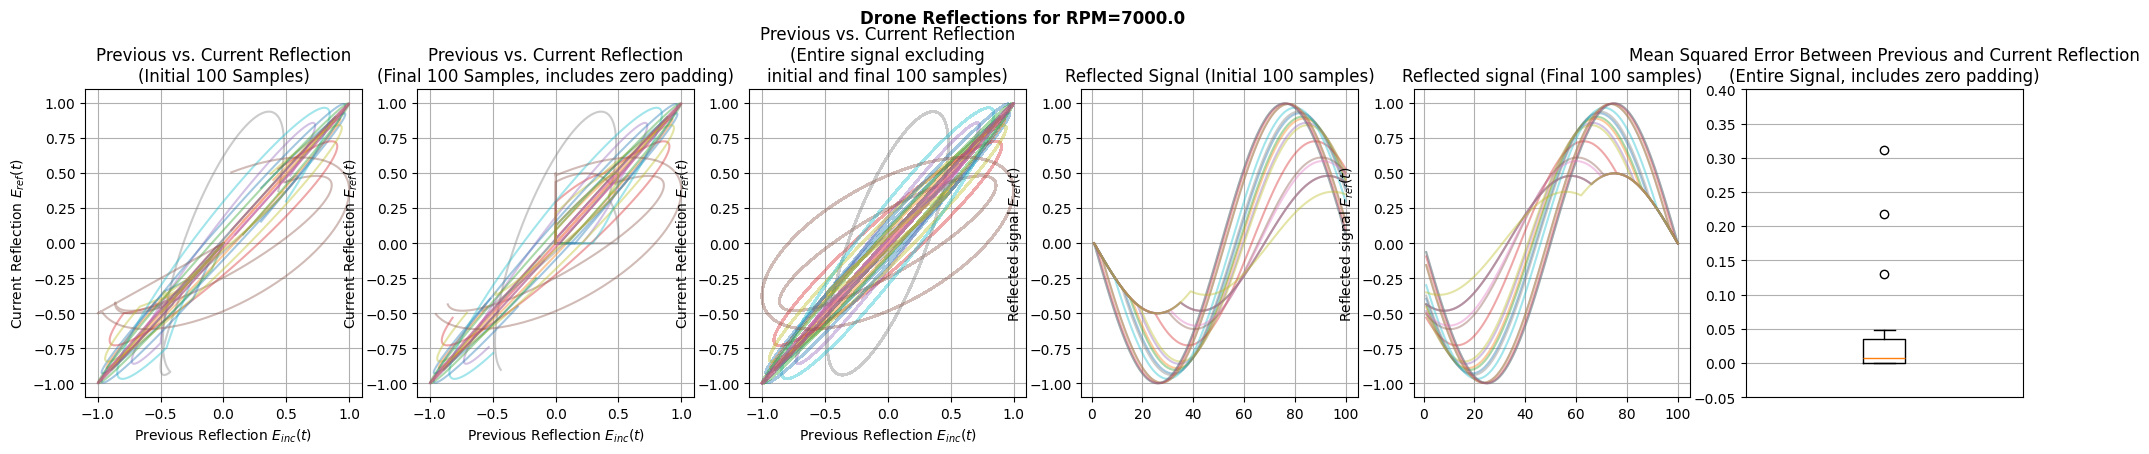

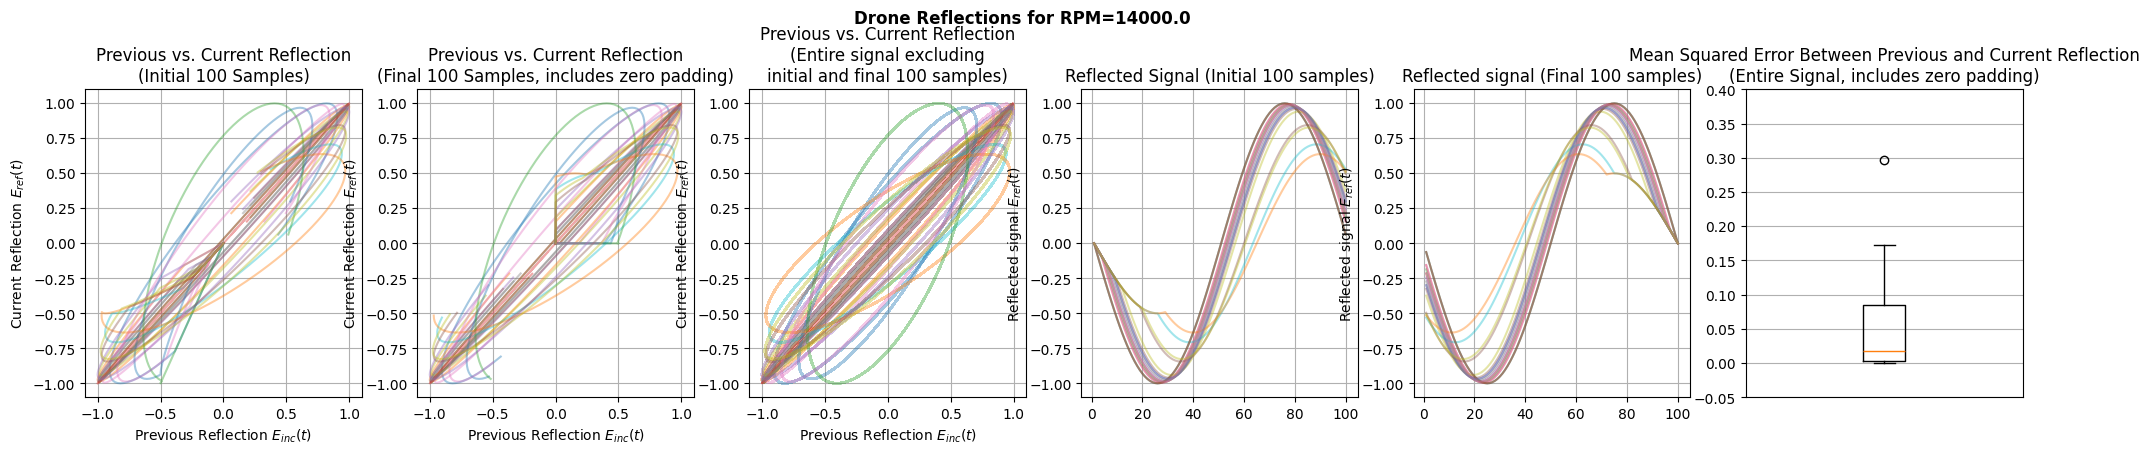

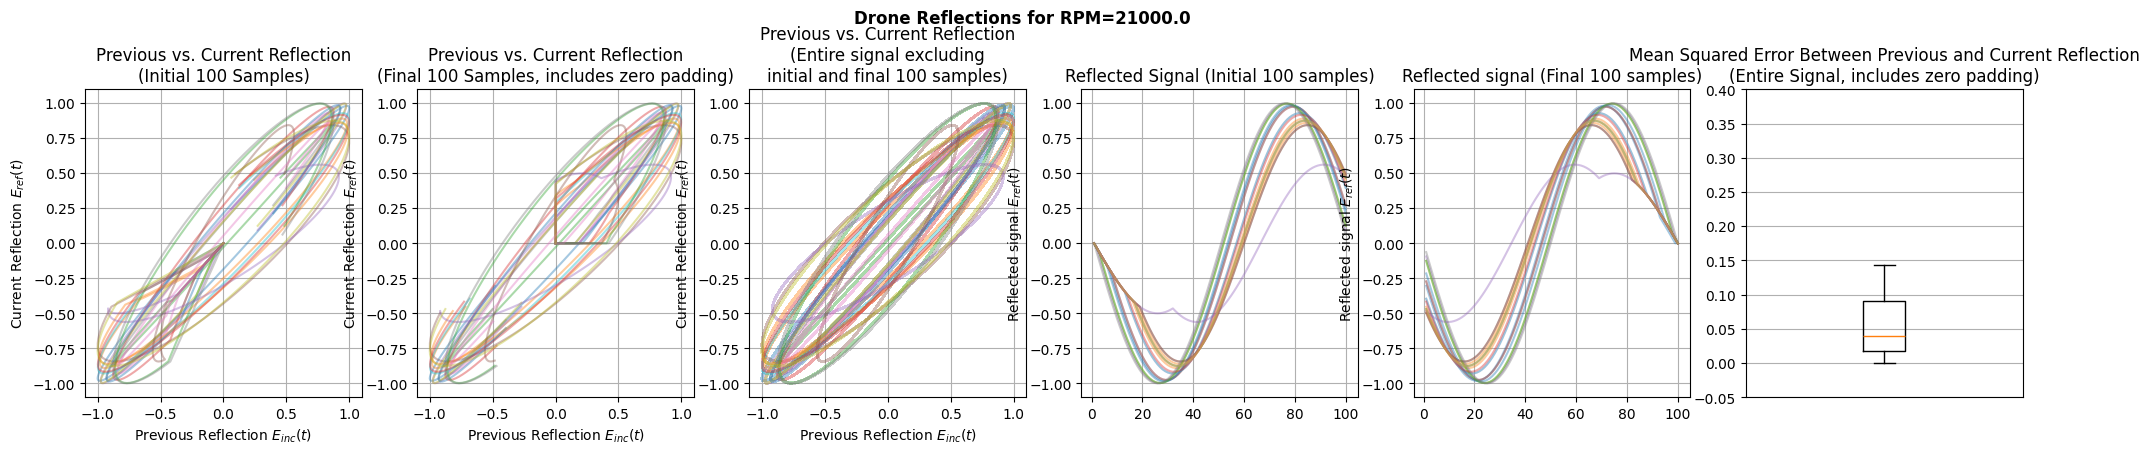

In [102]:
def plot_reflections(
    n_incident_signals=20,
    rpm=20e3,
    speed=40,
    propeller_diameter=0.12,
    distance=1000,
    random_state=0,
):
    signature_calculator = ExpectedSignatureCalculator(
        n_incident_signals,
        truncation_level=3,
        use_lead_lag_transformation=True,
        signal_to_noise_ratio=None,
    )
    fig, ax = plt.subplots(1, 6, figsize=(25, 4))
    if rpm:
        plt.suptitle(
            "Drone Reflections for RPM={}".format(rpm),
            fontweight="bold",
            verticalalignment="top",
            y=1.08,
        )
        signals = signature_calculator.compute_reflected_signals_for_drone(
            rpm, speed, propeller_diameter, distance, random_state
        )
    else:
        plt.suptitle(
            "Non-Drone Reflections", fontweight="bold", verticalalignment="top", y=1.08
        )
        signals = signature_calculator.compute_reflected_signals_for_nondrone(
            speed, distance, random_state=0
        )

    mean_squared_error = []
    for current_signal, previous_signal in zip(signals[1:], signals[:-1]):
        ax[3].plot(range(1, 101), current_signal[:100], alpha=0.4)
        ax[4].plot(range(1, 101), current_signal[-100:], alpha=0.4)

        current_signal, previous_signal = ExpectedSignatureCalculator._zero_pad(
            current_signal, previous_signal
        )
        mean_squared_error.append(np.mean((current_signal - previous_signal) ** 2))

        ax[0].plot(previous_signal[:100], current_signal[:100], alpha=0.4)
        ax[1].plot(previous_signal[-100:], current_signal[-100:], alpha=0.4)
        ax[2].plot(previous_signal[100:-100], current_signal[100:-100], alpha=0.4)

    ax[5].boxplot(mean_squared_error)

    ax[0].set_title("Previous vs. Current Reflection\n(Initial 100 Samples)")
    ax[0].set_xlabel("Previous Reflection $E_{inc}(t)$")
    ax[0].set_ylabel("Current Reflection $E_{ref}(t)$")
    ax[0].grid()
    ax[1].set_title(
        "Previous vs. Current Reflection\n(Final 100 Samples, includes zero padding)"
    )
    ax[1].set_xlabel("Previous Reflection $E_{inc}(t)$")
    ax[1].set_ylabel("Current Reflection $E_{ref}(t)$")
    ax[1].grid()
    ax[2].set_title(
        "Previous vs. Current Reflection\n(Entire signal excluding\ninitial and final 100 samples)"
    )
    ax[2].set_xlabel("Previous Reflection $E_{inc}(t)$")
    ax[2].set_ylabel("Current Reflection $E_{ref}(t)$")
    ax[2].grid()
    ax[3].set_title("Reflected Signal (Initial 100 samples)")
    ax[3].set_ylabel("Reflected signal $E_{ref}(t)$")
    ax[3].grid()
    ax[4].set_title("Reflected signal (Final 100 samples)")
    ax[4].set_ylabel("Reflected signal $E_{ref}(t)$")
    ax[4].grid()
    ax[5].set_title(
        "Mean Squared Error Between Previous and Current Reflection\n(Entire Signal, includes zero padding)"
    )
    ax[5].set_ylim((-0.05, 0.4))
    ax[5].grid()
    ax[5].set_xticks([])

    return signals[1:], signals[:-1]


current_signal, previous_signal = plot_reflections(rpm=None)
for random_state, rpm in enumerate((7e3, 14e3, 21e3)):
    current_signal, previous_signal = plot_reflections(
        rpm=rpm, random_state=random_state
    )

As observed from the first three columns, drone objects exhibit a characteristic shape in their plots of previous reflections against current reflections, compared to non-drone objects. The non-diagonal shape is the result of successively reflected signals being non-identical. As may be observed from the plots of the reflected signals, the propeller's position influences the delay between the onset of the body-reflected signal and onset of the propeller-reflected signal. Although less apparent from the first three columns, based on median values displayed in the box plots, the amount of departure from the diagonal appears to correlate with the RPM value.

These observations suggest that we might suitably use the signatures of paths obtained from successive reflections to distinguish between drone and non-drone objects, as well as predict the speed of the drone's propeller.

# Estimating Expected Path Signatures of Drone and Non-Drone Objects in Python

We seek to estimate the expected signatures of our drone and non-drone model, based on reflected signals that we generate as described previously. To this end, we implement a class which exposes the methods *compute_expected_signature_for_drone()* and *compute_expected_signature_for_nondrone()*.

To enable faster execution times on multi-processor systems, we use Joblib to compute path signatures in parallel. For additional convenience, using the function *cache_result()* we save results that we compute to a pickle file. Subsequently, we compute only those results that do not already exist in this pickle file.

In [103]:
def parallel_grid_search(function_to_execute, description, *parameter_ranges):
    parameter_space = list(itertools.product(*parameter_ranges))
    random_states = np.random.randint(np.iinfo(np.int32).max, size=len(parameter_space))

    # results = joblib.Parallel(n_jobs=multiprocessing.cpu_count(), backend='loky')(
    #     joblib.delayed(function_to_execute)(*parameter_combination, random_state)
    #     for parameter_combination, random_state in tqdm.notebook.tqdm(list(zip(parameter_space, random_states)),
    #                                                                   desc=description))
    results = joblib.Parallel(n_jobs=1, backend="loky")(
        joblib.delayed(function_to_execute)(*parameter_combination, random_state)
        for parameter_combination, random_state in tqdm.notebook.tqdm(
            list(zip(parameter_space, random_states)), desc=description
        )
    )

    return np.array(results), parameter_space

For each physical object, estimate expected signatures using 3000 emitted pulses. When running this notebook on a machine with limited computational resources, we recommend initially setting **N_INCIDENT_SIGNALS=300**.

In [104]:
N_INCIDENT_SIGNALS = 3000
TRUNCATION_LEVEL = 2
SIGNAL_TO_NOISE_RATIO = None

# Classification Task: Drone vs. Non-Drone
Next, we use expected signatures truncated to order $K=2$ to classify objects as 'drones' or 'non-drones'.

We estimate expected path signatures of drone and non-drone models, where we consider object speeds in the range $[0, 40]$ metres per second, object distances in the range $[50, 1000]$ metres, setting the propeller diameter and the propeller speed constant at 0.12 metres and 12000 rotations per minute, respectively. We seek to perform a logistic regression for predicting drone/non-drone class assignments, using expected path signatures as features.

In [105]:
np.random.seed(0)

signature_calculator = ExpectedSignatureCalculator(
    n_incident_signals=N_INCIDENT_SIGNALS,
    truncation_level=TRUNCATION_LEVEL,
    use_lead_lag_transformation=True,
    signal_to_noise_ratio=SIGNAL_TO_NOISE_RATIO,
)
rpms = [12000]
speeds = np.arange(0, 41, 2)
diameters = [
    0.12,
]
distances = np.arange(50, 1001, 200)


def get_drone_signatures_across_parameters(
    signature_calculator,
    rpms,
    speeds,
    diameters,
    distances,
    description="Drone signatures",
):
    return parallel_grid_search(
        signature_calculator.compute_expected_signature_for_drone,
        description,
        rpms,
        speeds,
        diameters,
        distances,
    )


def get_nondrone_signatures_across_parameters(
    signature_calculator, speeds, distances, description="Non-drone signatures"
):
    return parallel_grid_search(
        signature_calculator.compute_expected_signature_for_nondrone,
        description,
        speeds,
        distances,
    )


drone_signatures, _ = get_drone_signatures_across_parameters(
    signature_calculator, rpms, speeds, diameters, distances
)
nondrone_signatures, _ = get_nondrone_signatures_across_parameters(
    signature_calculator, speeds, distances
)

# Aggregate features, disregarding the 0th signature term
X = np.vstack((drone_signatures[:, 1:], nondrone_signatures[:, 1:]))
Y = np.append(np.ones(len(drone_signatures)), np.zeros(len(nondrone_signatures)))
feature_names = esig.sigkeys(3, signature_calculator.truncation_level).split(" ")[2:]

Drone signatures:   0%|          | 0/105 [00:00<?, ?it/s]

Non-drone signatures:   0%|          | 0/105 [00:00<?, ?it/s]

As an exploratory step, plot the values of expected path signature terms. (In the plots x, coordinate values are generated randomly for visualisation purposes.)

Note that since we apply the partial lead lag transformation to 2-dimensional streams $\hat{Y}$, there are 3 possible index values in the path signature. In the plots, index values 1 and 2 refer to the lead-transformed input stream $\hat{Y}^{\text{lead}}$, whereas index value 3 refers to the lag-transformed second dimension of the input stream $\hat{Y}^{\text{lag}}_{\text{ref}}$.

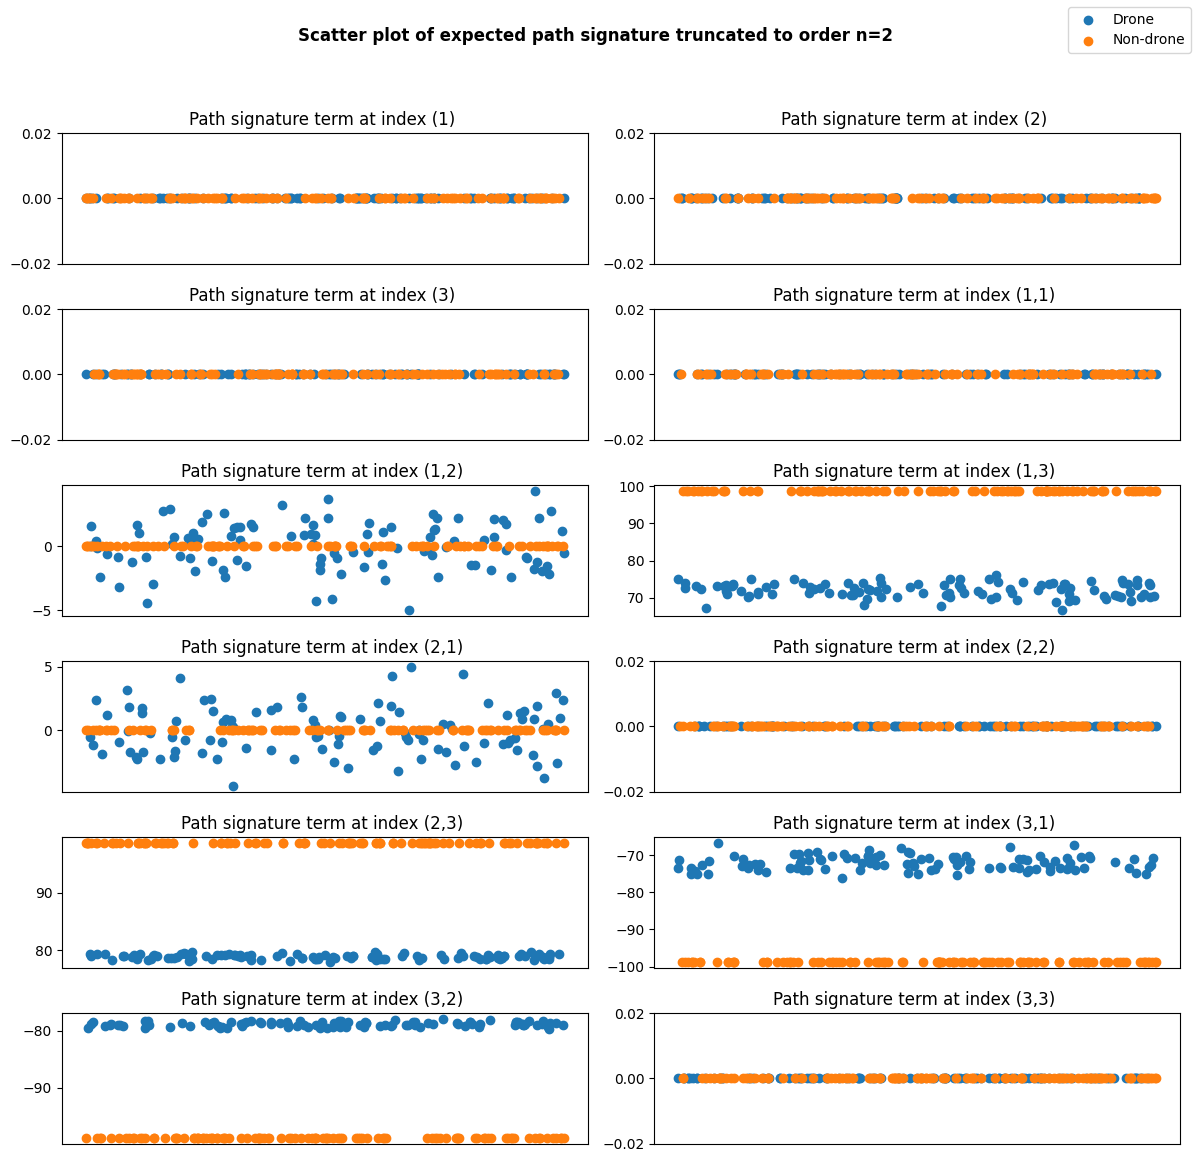

In [106]:
def plot_feature(X, Y, feature_index, ax, features=feature_names):
    X_grouped = {cls: X[Y == cls, feature_index] for cls in (True, False)}

    for cls in (True, False):
        ax.scatter(np.random.uniform(size=len(X_grouped[cls])), X_grouped[cls])

    all_yvalues = np.concatenate([X_grouped[True], X_grouped[False]])
    range_yvalue = np.max(all_yvalues) - np.min(all_yvalues)
    if range_yvalue < 1:
        ax.set_yticks([-0.02, 0, 0.02])

    ax.set_xticks([])
    ax.set_title(
        "Path signature term at index {} ".format(features[feature_index], ddof=1)
    )


fig, axs = plt.subplots(
    int(np.ceil(X.shape[1] / 2)),
    2,
    figsize=(12, np.ceil(X.shape[1] / 2) * 2.0),
    sharey=False,
)
fig.suptitle(
    "Scatter plot of expected path signature truncated to order n={}".format(
        signature_calculator.truncation_level
    ),
    fontweight="bold",
    verticalalignment="top",
)

for feature_index in range(X.shape[1]):
    # print("X.shape[1]=", X.shape[1])
    plot_feature(X, Y, feature_index, np.ravel(axs)[feature_index])

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.legend(labels=("Drone", "Non-drone"), loc="upper right")
plt.show()

From the plots, we observe we observe that path signature terms at indices $(1,~3)$, $(2,~3)$, $(3,~1)$, $(3,~2)$ appear to be good candidate features for predicting class membership, as well as the absolute values of path signature terms at indices $(1,~2)$, $(2,~1)$. As an aside, it may also be instructive to consider the differences between path signature terms, representing areas:

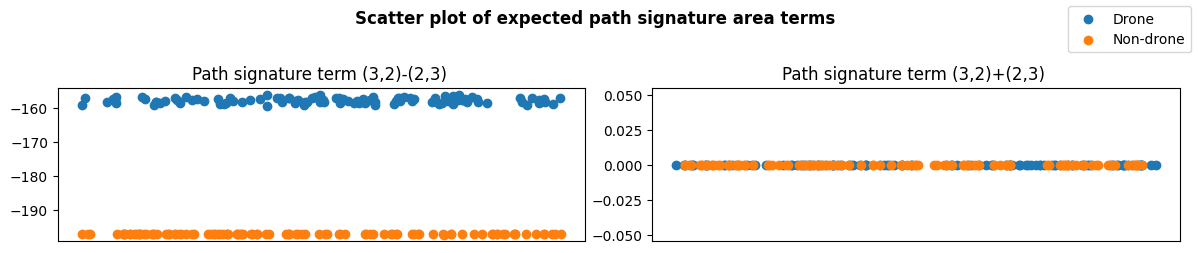

In [107]:
def plot_areas(X, Y, feature_index, ax, features=feature_names, area_sign="-"):
    i__3_2 = np.array(feature_names) == "(3,2)"
    i__2_3 = np.array(feature_names) == "(2,3)"
    if area_sign == "-":
        X_grouped = {
            cls: X[Y == cls, i__3_2] - X[Y == cls, i__2_3] for cls in (True, False)
        }
    else:
        X_grouped = {
            cls: X[Y == cls, i__3_2] + X[Y == cls, i__2_3] for cls in (True, False)
        }

    for cls in (True, False):
        ax.scatter(np.random.uniform(size=len(X_grouped[cls])), X_grouped[cls])

    ax.set_xticks([])
    if area_sign == "-":
        ax.set_title(
            "Path signature term (3,2)-(2,3) ".format(features[feature_index], ddof=1)
        )
    else:
        ax.set_title(
            "Path signature term (3,2)+(2,3) ".format(features[feature_index], ddof=1)
        )


fig, axs = plt.subplots(1, 2, figsize=(12, 2.6), sharey=False)
fig.suptitle(
    "Scatter plot of expected path signature area terms",
    fontweight="bold",
    verticalalignment="top",
)

plot_areas(X, Y, feature_index, axs[0], area_sign="-")
plot_areas(X, Y, feature_index, axs[1], area_sign="+")

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.legend(labels=("Drone", "Non-drone"), loc="upper right")
plt.show()

For completeness, we fit a logistic regression model. We first evaluate the effect of the regularisation parameter on in-sample and out-of-sample performance, where we quantify performance using cross entropy. With respect to testing data performance, using the optimal regularisation parameter value, we then compute a receiver operating characteristic (ROC) curve.

In [108]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(
    X, Y, test_size=0.33, random_state=0
)

regularisation_strengths = np.logspace(-20, 20, 100)
penalty = "l2"
model = sklearn.linear_model.LogisticRegression(
    penalty=penalty, random_state=0, solver="liblinear"
)
pipeline = sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), model)

train_results = []
test_results = []
for reg_strength in regularisation_strengths:
    model.set_params(C=1 / reg_strength)
    pipeline.fit(X_train, Y_train)
    train_results.append(
        sklearn.metrics.log_loss(Y_train, pipeline.predict_proba(X_train))
    )
    test_results.append(
        sklearn.metrics.log_loss(Y_test, pipeline.predict_proba(X_test))
    )

i_optim = np.argmin(test_results)
regularisation_strength_optim = regularisation_strengths[i_optim]

# Estimate final model using optimal regularisation parameter value
model.set_params(C=1 / regularisation_strength_optim)
pipeline.fit(X_train, Y_train)

final_results = {}
final_results["accuracy"] = pipeline.score(X_test, Y_test)
final_results["fpr"], final_results["tpr"], _ = sklearn.metrics.roc_curve(
    Y_test, pipeline.predict_proba(X_test)[:, 1]
)
final_results["auc"] = sklearn.metrics.auc(final_results["fpr"], final_results["tpr"])

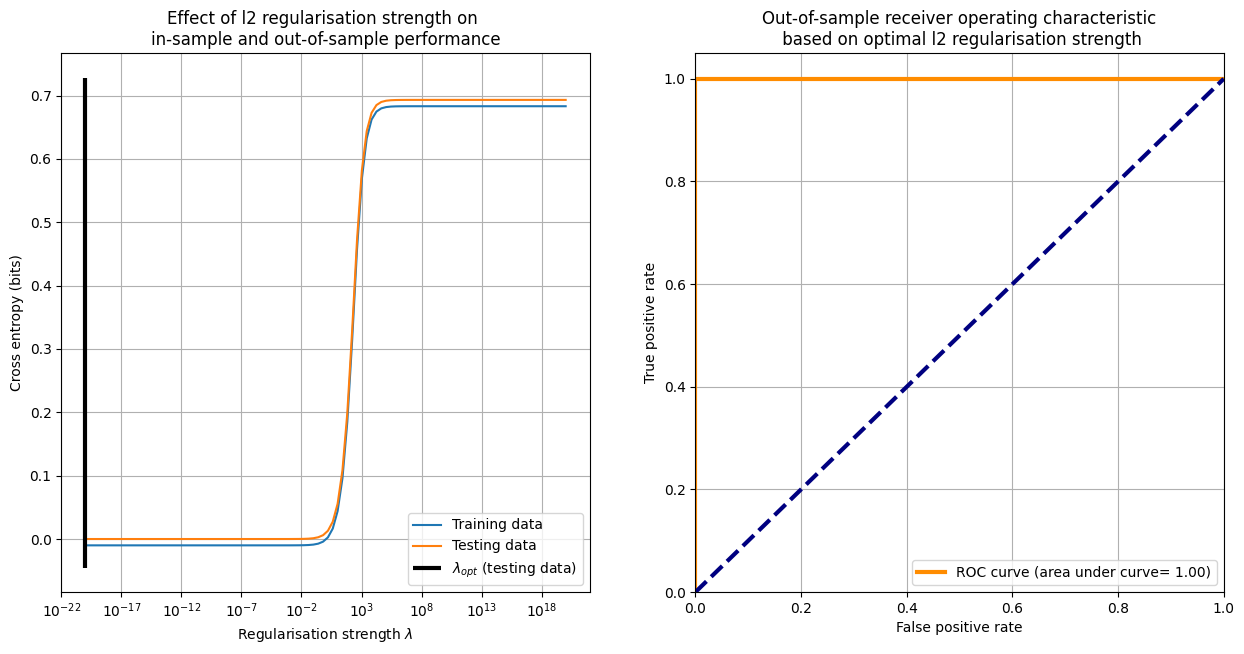

In [109]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.semilogx(
    regularisation_strengths, np.array(train_results) - 0.01, label="Training data"
)
plt.semilogx(regularisation_strengths, np.array(test_results), label="Testing data")
plt.vlines(
    regularisation_strength_optim,
    plt.ylim()[0],
    plt.ylim()[1],
    color="k",
    linewidth=3,
    label="$\lambda_{opt}$ (testing data)",
)
plt.legend(loc="lower right")
plt.xlabel("Regularisation strength $\lambda$")
plt.ylabel("Cross entropy (bits)")
plt.title(
    "Effect of {} regularisation strength on \nin-sample and out-of-sample performance".format(
        penalty
    )
)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(
    final_results["fpr"],
    final_results["tpr"],
    color="darkorange",
    linewidth=3,
    label="ROC curve (area under curve= %0.2f)" % final_results["auc"],
)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--", linewidth=3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title(
    "Out-of-sample receiver operating characteristic\n based on optimal {} regularisation strength".format(
        penalty
    )
)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Regression Task: Predicting RPM Values
Next, we use expected signatures truncated to order $K=2$ to predict the propeller's RPM in our drone model. That is, we seek a function $h$ that takes the expected signature $E(S)$ of our drone model as its input, and outputs the drone's RPM value $R$,

$$R = h\big( E(S) \big)$$

According to the Stone-Weierstrass theorem, we may approximate $h$ arbitrarily closely using a linear combination $\tilde{h}$ of terms of the non-truncated expected signature $E(S)$. From a theoretical standpoint, this motivates our decision to perform linear regression on our truncated expected signature estimates.

For our regression task, we estimate expected path signatures of drone models, where we consider RPM values in the range $[8000, 20000]$, object speeds in $\{0, 20, 40\}$ metres per second, object distances in $\{50, 500, 1000\}$ metres, leaving the propeller diameter set constant at $0.12$ metres. We assume that 80% of signals reflect of the drone's body, with the remainder reflecting off the propeller. To help ensure that we evaluate on unseen data, we construct training and testing data using disjoint sets of RPM values.

In [110]:
np.random.seed(1)

signature_calculator = ExpectedSignatureCalculator(
    n_incident_signals=N_INCIDENT_SIGNALS,
    truncation_level=TRUNCATION_LEVEL,
    use_lead_lag_transformation=True,
    signal_to_noise_ratio=SIGNAL_TO_NOISE_RATIO,
)

rpms = np.arange(8000, 20001, 200)
speeds = [0, 20, 40]
diameters = [0.12]
distances = [50, 500, 1000]

drone_signatures, parameter_combinations = get_drone_signatures_across_parameters(
    signature_calculator,
    rpms,
    speeds,
    diameters,
    distances,
    description="Signatures at RPMS",
)

combinations_rpm, combinations_speed, *_ = list(zip(*parameter_combinations))

# Aggregate features, disregarding the 0th signature term
X = drone_signatures[:, 1:]
Y = np.array(combinations_rpm)
feature_names = esig.sigkeys(3, signature_calculator.truncation_level).split(" ")[2:]

# Create equal train/test split, ensuring that test / training data are disjoint in terms of RPM values
I_train, I_test = list(
    sklearn.model_selection.GroupKFold(n_splits=2).split(X, Y, groups=combinations_rpm)
)[0]
X_train, Y_train = X[I_train], Y[I_train]
X_test, Y_test = X[I_test], Y[I_test]
speed_train = np.array(combinations_speed)[I_train]

Signatures at RPMS:   0%|          | 0/549 [00:00<?, ?it/s]

As an exploratory step, plot Pearson correlations and their confidence intervals between expected path signature terms and the drone's RPM value, for the training data and for each considered object speed:

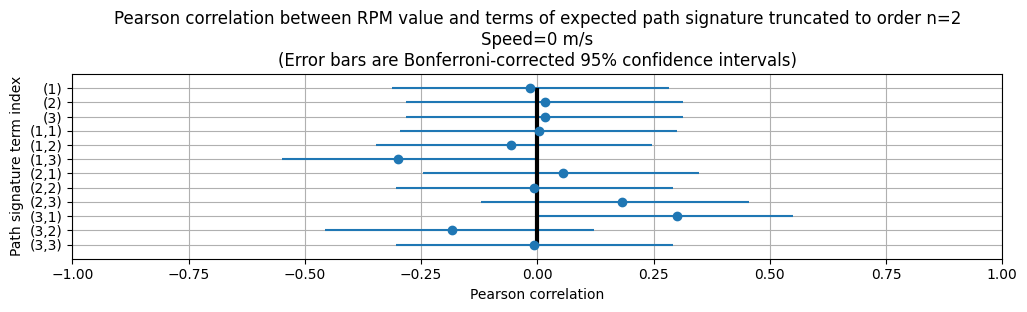

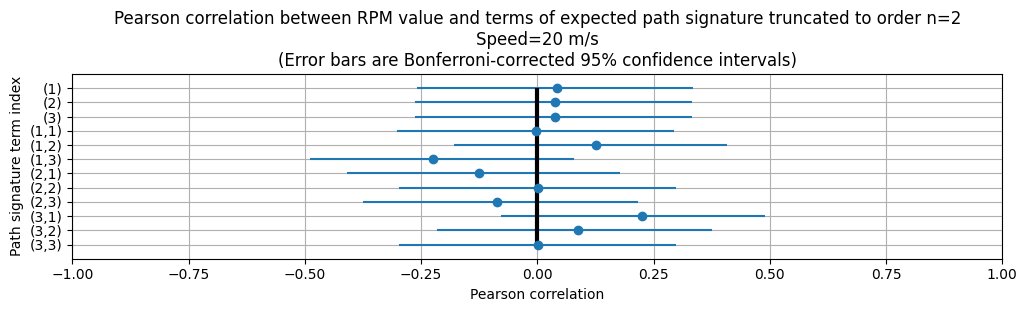

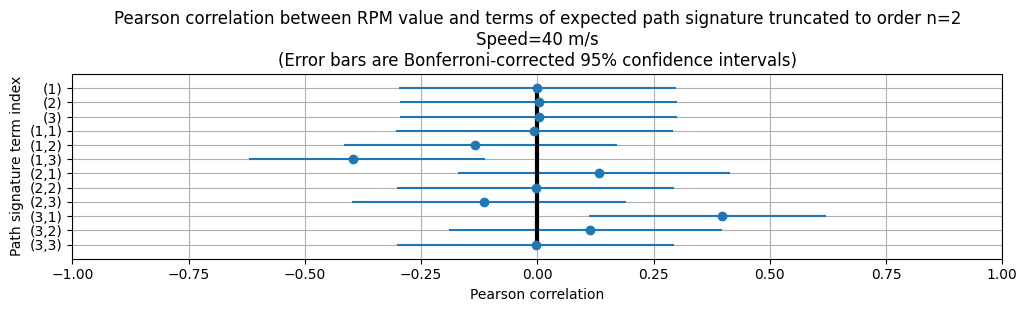

In [111]:
def r_to_z(r):
    # Convert r to z'
    return np.log((1 + r) / (1 - r)) / 2.0


def z_to_r(z):
    # Convert z' to r
    e = np.exp(2 * z)
    return (e - 1) / (e + 1)


def pearson_r_confidence_interval(r, n, alpha=0.95):
    # See http://onlinestatbook.com/2/estimation/correlation_ci.html
    # See https://stackoverflow.com/q/33176049

    z = r_to_z(r)
    se = 1.0 / np.sqrt(n - 3)
    z_crit = scipy.stats.norm.ppf((1 + alpha) / 2)  # 2-tailed z critical value

    lo = z - z_crit * se
    hi = z + z_crit * se

    return np.array((r - z_to_r(lo), z_to_r(hi) - r))


def plot_correlations(X, Y, speed, feature_names):
    correlations = np.array(
        [scipy.stats.pearsonr(X[:, i], Y)[0] for i in range(X.shape[1])]
    )  # TODO pearsonr
    # Bonferroni-corrected confidence intervals
    confidence_intervals = pearson_r_confidence_interval(
        correlations, len(Y), 1 - 0.05 / len(feature_names)
    )

    plt.figure(figsize=(12, 0.2 * len(feature_names)))

    y = np.arange(len(correlations))
    plt.errorbar(correlations, y, xerr=confidence_intervals, fmt="o")
    plt.vlines(0, min(y), max(y), color="k", linewidth=3)

    plt.yticks(y, feature_names)
    plt.xlabel("Pearson correlation")
    plt.ylabel("Path signature term index")
    plt.gca().invert_yaxis()
    plt.xlim([-1, 1])
    plt.ylim([len(correlations), -1])
    plt.title(
        "Pearson correlation between RPM value and terms of expected path signature truncated to order n={}\n"
        "Speed={} m/s\n"
        "(Error bars are Bonferroni-corrected 95% confidence intervals)".format(
            signature_calculator.truncation_level, speed
        )
    )
    plt.grid(True)
    plt.show()


for speed in speeds:
    I = np.array(speed_train) == speed
    plot_correlations(X_train[I], Y_train[I], speed, feature_names)

As observed when distinguishing between object speeds, we observe significant correlations between the RPM values and path signature terms at indices $(1,~3)$, $(3,~1)$.

Next, we fit the regression model. We first evaluate the effect of the regularisation parameter on in-sample and out-of-sample performance, where we quantify performance using the $R^2$ statistic. With respect to testing data performance, using the optimal regularisation parameter value, we then plot predicted and true RPM values.

In [112]:
regularisation_strengths = np.logspace(-20, 10, 100)
penalty = "l2"
model = sklearn.linear_model.Ridge(fit_intercept=True, random_state=0)
pipeline = sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), model)

train_results = []
test_results = []
final_results = []

for reg_strength in regularisation_strengths:
    model.set_params(alpha=reg_strength)
    pipeline.fit(X_train, Y_train)
    train_results.append(sklearn.metrics.r2_score(Y_train, pipeline.predict(X_train)))
    test_results.append(sklearn.metrics.r2_score(Y_test, pipeline.predict(X_test)))

i_optim = np.argmax(test_results)
regularisation_strength_optim = regularisation_strengths[i_optim]

# Estimate final model using optimal regularisation parameter value
model.set_params(alpha=regularisation_strength_optim)
pipeline.fit(X_train, Y_train)

final_results = {}
final_results["r2"] = sklearn.metrics.r2_score(Y_test, pipeline.predict(X_test))
final_results["predictions"] = pipeline.predict(X_test)

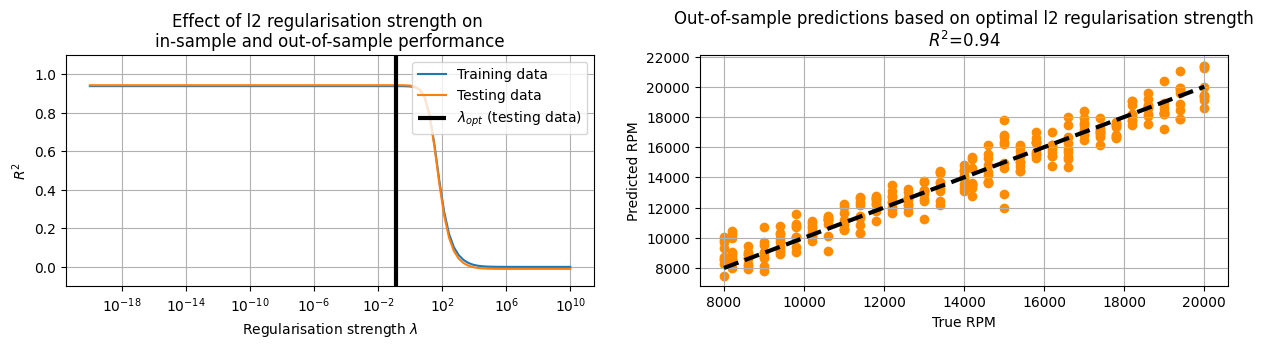

In [113]:
plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.title(
    "Effect of {} regularisation strength on \nin-sample and out-of-sample performance".format(
        penalty
    )
)
plt.semilogx(regularisation_strengths, train_results, label="Training data")
plt.semilogx(regularisation_strengths, test_results, label="Testing data")
plt.ylim([-0.1, 1.1])
plt.vlines(
    regularisation_strength_optim,
    plt.ylim()[0],
    plt.ylim()[1],
    color="k",
    linewidth=3,
    label="$\lambda_{opt}$ (testing data)",
)
plt.legend(loc="upper right")
plt.xlabel("Regularisation strength $\lambda$")
plt.ylabel("$R^2$")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title(
    "Out-of-sample predictions based on optimal {} regularisation strength\n"
    "$R^2$={:.2}".format(penalty, final_results["r2"])
)
plt.scatter(Y_test, final_results["predictions"], color="darkorange")
plt.plot(
    [min(Y_test), max(Y_test)],
    [min(Y_test), max(Y_test)],
    color="k",
    linestyle="--",
    linewidth=3,
)
plt.xlabel("True RPM")
plt.ylabel("Predicted RPM")
plt.grid(True)
plt.show()

As observed, with respect to testing data our model predicts RPMs with an $R^2$ statistic of 0.94.

# Conclusion
This notebook explored the use of path signatures for distinguishing between simulated drone and non-drone objects. Based on estimating expected path signatures up to level $K=2$ from pairs reflected signals, results suggest that path signature features are an informative low-dimensional representation for the considered task.

# Future Work
This notebook aims to demonstrate the use of path signatures qualitatively and from a practical perspective, using $\texttt{esig}$. Improvements to this notebook might involve the following:
* Applying noise to reflected signals
* Simulating multi-path behaviour in reflected signals
* Exploring the effect of parameter combinations on model performance in further detail

## References

$[1]$ Cooper. J, "Scattering of electromagnetic fields by a moving boundary - The one-dimensional case", $\textit{IEEE Transactions on Antennas and Propagation}$, vol. AP-28, Nov. 1980, p. 791-795.

$[2]$ Rahkmanov. M, "Reflection of light from a moving mirror: derivation of the relativistic Doppler formula without Lorentz transformations", 	arXiv:physics/0605100 [physics.ed-ph]

$[3]$ B.M. Hambly and Terry Lyons, "Uniqueness for the signature of a path of bounded variation and the reduced path group.", $\textit{Annals of Mathematics}$, 171(1):109–167, 2010.

$[4]$ Ilya Chevyrev and Terry Lyons, "Characteristic functions of measures on geometric rough paths.", Annals of Probability, Volume 44, Number 6 (2016), 4049-4082

$[5]$ Ilya Chevyrev and Andre Kormilitzin, "A Primer on the Signature Method in Machine Learning.", arXiv:1603.03788 [stat.ML]

$[6]$ Daniel Levin, Terry Lyons, Hao Ni, "Learning from the past, predicting the statistics for the future, learning an evolving system", 	arXiv:1309.0260 [q-fin.ST]

$[7]$ Gyurkó, Lajos Gergely, Terry Lyons, Mark Kontkowski, and Jonathan Field. "Extracting information from the signature of a financial data stream." arXiv:1307.7244 (2013).